In [11]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import os

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
filepath = '/Users/mteodoro/IMAGES/ETACAR/MAST_2022-07-13T1256/HST/ie2w04020'
filename = 'ie2w04020_drz.fits'
path = os.path.join(filepath, filename)

hdu = fits.open(path)
wcs_in = WCS(hdu['SCI'].header)

Determine the optimal WCS for the image (by default the final WCS will be oriented North-Up East-Left)

In [6]:
wcs_out, shape_out = find_optimal_celestial_wcs([hdu['SCI']])

Apply the optimal WCS transformations to the original image and save the result

In [10]:
array, footprint = reproject_and_coadd([hdu['SCI']], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

Text(0.5, 1.0, 'NUEL Oriented')

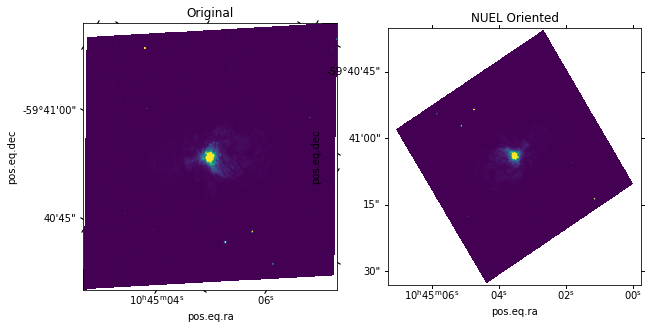

In [21]:
plt.figure(figsize=(10, 8))

vmin = 0
vmax = 100

ax1 = plt.subplot(1, 2, 1, projection=wcs_in)

im1 = ax1.imshow(hdu['SCI'].data, origin='lower', vmin=vmin, vmax=vmax)

ax1.set_title('Original')

ax2 = plt.subplot(1, 2, 2, projection=wcs_out)

im2 = ax2.imshow(array, origin='lower', vmin=vmin, vmax=vmax)

ax2.set_title('NUEL Oriented')